In [1]:
import torch 
import torch.nn as nn 

import h5py, os
import numpy as np
from matplotlib import pyplot as plt
from functions import transforms as T
from torch.nn import functional as F
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from math import exp
from torch.autograd import Variable

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available

In [3]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [4]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [5]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    # mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    mask_func = MaskFunc(center_fractions=center_fract, accelerations=acc)
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    # img_gt, img_und = T.complex_center_crop(img_gt, (320,320)), T.complex_center_crop(img_und, (320,320))

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
    
    # print(img_gt.std(), img_und.std())
        
    return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

In [6]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list  

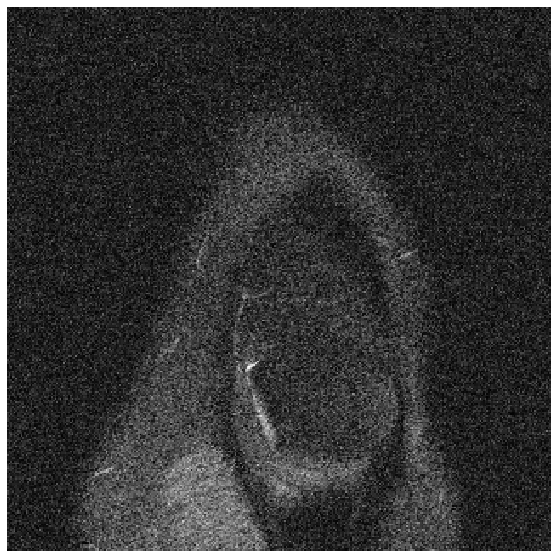

In [7]:
#PREPARE THE DATA 
data_list = load_data_path('/data/local/NC2019MRI/train', '/data/local/NC2019MRI/train')
# slices, height, width = input_k.shape()

acc = [4,8]
cen_fract = [0.08, 0.04]
# acc = [4]
# cen_fract = [0.08]
seed = False # random masks for each slice 
num_workers = 16 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data

def my_collate(batch):
    batch_len = len(batch)
    data = torch.ones(batch_len, 1, 320, 320)
    target_list = torch.ones(batch_len, 1, 320, 320)
    
    for batch_value in range(len(batch)):
        input = batch[batch_value][1]
        input = T.complex_abs(input)
        input = T.center_crop(input, (320, 320))
        data[batch_value, 0, :, :] = input
        
        target = batch[batch_value][0]
        target = T.complex_abs(target)
        target = T.center_crop(target, (320, 320))
        target_list[batch_value, 0, :, :] = target
    return (target_list, data, None, None, None)
    
# create data loader for training set. It applies same to validation set as well
train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=14, num_workers=num_workers, collate_fn=my_collate)


for iteration, sample in enumerate(train_loader):
    
    img_gt, img_und, _, _, _ = sample
    D = img_gt.squeeze()
    
    # from left to right: mask, masked kspace, undersampled image, ground truth
    show_slices([D[0]], [0], cmap='gray')
    if iteration < 1: break
#make x_train_tensor and y_train_tensor

#from torch.utils.data import TensorDataset, DataLoader

#train_data = TensorDataset(x_train_tensor, y_train_tensor)
#train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)


In [8]:
class ConvolutionalBlock(nn.Module):
    """
    2 lots of:
        3x3 convolutional blocks
        Instance Normalisation 
        ReLu
        Dropout 
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )
        

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        #print('input', input.shape)
        return self.layers(input)



In [9]:
class NeuralNetworkModel(nn.Module):
    """
        Unet model
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()
        

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.layers_list_downsample = nn.ModuleList()
        convblock_1 = ConvolutionalBlock(in_chans, chans, drop_prob)
        self.layers_list_downsample += [convblock_1]
        
        #print(in_chans, chans)
        
        ch = chans
        #create a new convolutionalm block for each layer, doubling the number of channels to downsample 
        for i in range(num_pool_layers - 1):
            new_convBlock = ConvolutionalBlock(ch, ch * 2, drop_prob)
            self.layers_list_downsample += [new_convBlock]
            #print(ch, ch*2)
            ch *= 2
        #one for convolution block with the same number of channels as the previous    
        self.conv = ConvolutionalBlock(ch, ch, drop_prob)
        #print(ch, ch)

        #the same thing but decreasing the chanells to upsample 
        self.layers_list_upsample = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            new_convBlock = ConvolutionalBlock(ch * 2, ch // 2, drop_prob)
            self.layers_list_upsample += [new_convBlock]
            #print(ch * 2, ch // 2)
            ch //= 2
        self.layers_list_upsample += [ConvolutionalBlock(ch * 2, ch, drop_prob)]
        #print(ch*2, ch)
        
        #2 convolution layers to build the data up to the same size at the input 
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )
        #print(ch, ch // 2 )
        #print(ch // 2, out_chans)
        #print(out_chans, out_chans)

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.layers_list_downsample:
            output = layer(output)
            #print('output', output.shape)
            stack.append(output)
            #apply 2x2 max pooling 
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)
        #print('output', output.shape)
        
        #print('up-sampling')

        # Apply up-sampling layers
        for layer in self.layers_list_upsample:
            #print(output.shape, stack[-1].shape)
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            #print(output.shape, stack[-1].shape)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

In [10]:
import torch.optim as optim

#create a model
model = NeuralNetworkModel(
    in_chans=1,
    out_chans=1,
    chans=32,
    num_pool_layers=4,
    drop_prob=0.0
).to(device)

#inspect parameters 
# print("Before training: \n", model.state_dict())

In [11]:
#loss function
#start point: L1 loss |output - gold standard|

#ssim loss
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret


# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
        
        if channel == self.channel and self.window.type == img1.type:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        return 1 - ssim(img2, img1, window=window, window_size=self.window_size, size_average=self.size_average, val_range=img2.max())
        
def msssim(img1, img2, window_size=11, size_average=True, val_range=None, normalize=True):
    device = img1.device
    weights = torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).to(device)
    levels = weights.size()[0]
    mssim = []
    mcs = []
    for _ in range(levels):
        sim, cs = ssim(img1, img2, window_size=window_size, size_average=size_average, full=True, val_range=val_range)
        mssim.append(sim)
        mcs.append(cs)

        img1 = F.avg_pool2d(img1, (2, 2))
        img2 = F.avg_pool2d(img2, (2, 2))


    mssim = torch.stack(mssim)
    mcs = torch.stack(mcs)

    # Normalize (to avoid NaNs during training unstable models, not compliant with original definition)
    if normalize:
        mssim = (mssim + 1) / 2
        mcs = (mcs + 1) / 2

    pow1 = mcs ** weights
    pow2 = mssim ** weights
    # From Matlab implementation https://ece.uwaterloo.ca/~z70wang/research/iwssim/
    output = torch.prod(pow1[:-1] * pow2[-1])
    return output


class MSSSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, channel=3):
        super(MSSSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = channel

    def forward(self, img1, img2):
        # TODO: store window between calls if possible
        return 1 - msssim(img1, img2, window_size=self.window_size, size_average=self.size_average, val_range=img1.max())
    
ssim_loss = SSIM()
msssim_loss = MSSSIM()
#VGG loss

#GAN loss 

#L2 mean squared error between the output and the gold standard 

#mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean')

In [12]:
# set learning rate
lr = 1e-4
wd = 0.0
#optimiser
#stochastic gradient descent (SGD)
# optimiser = optim.SGD(model.parameters(), lr=lr)
optimiser = optim.Adam(model.parameters(), lr=lr)
# optimiser = torch.optim.RMSprop(model.parameters(), lr, weight_decay=wd)

In [13]:
#train the network 

# set number of epoches, i.e., number of times we iterate through the training set
epoches = 20

for epoch in range(epoches):
    model.train() 
    mean = []
    for iter, data in enumerate(train_loader):
        target, input, _, _, _ = data
        # print(input.shape)
        input = input.to(device)
        # print(input.shape)
        # print(target.shape)
        target = target.to(device)

        output = model(input)
        # print(output.shape)
        loss = ssim_loss(output, target)
        # loss = msssim_loss(output, target)
        # loss = F.l1_loss(output, target)
        mean.append(loss)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    print("Epoch {}'s loss: {}".format(epoch, sum(mean)/len(mean)))
# print("After training: \n", model.state_dict())


Epoch 0's loss: 0.7352574467658997
Epoch 1's loss: 0.49669113755226135
Epoch 2's loss: 0.41145452857017517
Epoch 3's loss: 0.38900166749954224
Epoch 4's loss: 0.37703055143356323


In [14]:
from skimage.measure import compare_ssim 
def ssim_np(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [15]:
for iteration, sample in enumerate(train_loader):
    
    img_gt, img_und, _, _, _  = sample
    D = img_gt.squeeze()
    C = img_und.squeeze()
    
    snp = ssim_np(D.cpu().detach().numpy(), C.cpu().detach().numpy())
    spy = 1 - ssim_loss(C.unsqueeze(0).to(device), D.unsqueeze(0).to(device))
    
    print(snp, spy)
    # print(D.shape, D.unsqueeze(0).shape)
    
    # show_slices([D[0], C[0]], [0, 1], cmap='gray')
    if iteration >= 10: break

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.5501071896680699 tensor(0.5507, device='cuda:0')
0.5897546048952125 tensor(0.5954, device='cuda:0')
0.5961351589454073 tensor(0.6018, device='cuda:0')
0.6938788695043581 tensor(0.7011, device='cuda:0')
0.598302807235098 tensor(0.6033, device='cuda:0')
0.5970857088021189 tensor(0.6030, device='cuda:0')
0.5072443215799641 tensor(0.5113, device='cuda:0')
0.5724955347306269 tensor(0.5768, device='cuda:0')
0.6578282980619549 tensor(0.6652, device='cuda:0')
0.5908600671938099 tensor(0.5959, device='cuda:0')
0.542855633543178 tensor(0.5476, device='cuda:0')


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.524255152635992
torch.Size([1, 14, 320, 320])
torch.Size([1, 14, 320, 320])
tensor(0.5284, device='cuda:0', grad_fn=<RsubBackward1>)


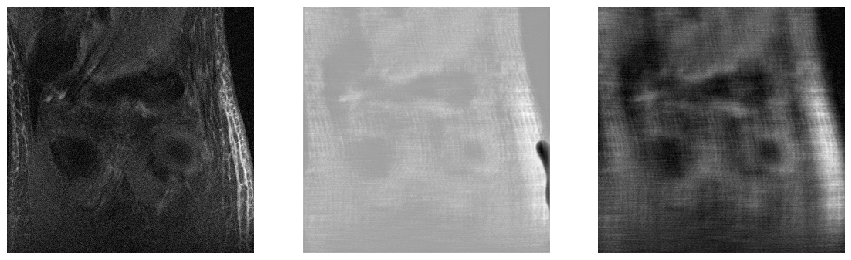

In [17]:
for iteration, sample in enumerate(train_loader):
    
    img_gt, img_und, _, _, _  = sample
    D = img_gt.squeeze()
    
    C = img_und
    input = C.to(device)
    # print(img_gt.shape) torch.Size([14, 1, 320, 320])
    
    output = model(input).cpu().detach().numpy().squeeze()
    
    # print(output.shape) (14, 320, 320)
    # print(D.shape) torch.Size([14, 320, 320])
    print(ssim_np(D.cpu().detach().numpy(), output))
    # from left to right: mask, masked kspace, undersampled image, ground truth
    show_slices([D[0], output[0], C.squeeze()[0]], [0, 1, 2], cmap='gray')
    print(model(input).squeeze(1).unsqueeze(0).shape)
    print(img_gt.squeeze(1).unsqueeze(0).to(device).shape)
    print(1 - ssim_loss(model(input).squeeze(1).unsqueeze(0), img_gt.squeeze(1).unsqueeze(0).to(device)))
    if iteration < 1: break